In [1]:
import sys
sys.path.append("..")
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [2]:
import utils.dataset as myDataset
import model.model as myModel
import utils.loss as myLoss


In [3]:
arg_batchSize =32
arg_pretrainedModel = "../model/pretrainedModel/final_test_facedet.pt"
arg_workers = 12
arg_dataset = "../data/"
arg_split = "train"
arg_outputPath = "../data/savings/output/"
arg_heatmapName = "_test.npy"

In [4]:
dataset = myDataset.FaceDataset(datapath = arg_dataset, split = arg_split)
dataloader = torch.utils.data.DataLoader(dataset, shuffle = True, batch_size = arg_batchSize, \
                                         num_workers = arg_workers, drop_last = False)

7050it [01:05, 107.82it/s]


In [5]:
model = myModel.FaceKeypointModel()
model.load_state_dict(torch.load(arg_pretrainedModel))
print("Use model from " + arg_pretrainedModel)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()
model.to(device)

if not os.path.exists(arg_outputPath):
    os.makedirs(arg_outputPath)

heatmap_num = 0

Use model from ../model/pretrainedModel/final_test_facedet.pt


In [6]:
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloader)):
        if arg_split == "train":
            image, anno, gtmap = data
            image, anno, gtmap= image.to(device,  dtype=torch.float), anno.to(device), gtmap.to(device, dtype=torch.float)
            image = image/255.0
        else:
            image = data
            image = image.to(device, dtype=torch.float)
            image = image/255.0
        
        
        
        heatMaps = model(image)
        # heatMaps = F.max_pool2d(heatMaps, 3, 1, 1, 1)
        heatmap_num = heatmap_num + 1
        
        break


0it [00:01, ?it/s]


In [ ]:
kpPosList = []

for i in range(heatMaps.shape[0]):
    heatMap = heatMaps[i]
    kpPos = []
    
    for kpID in range(15):
        heatMapkp = heatMap[kpID]
        indices = torch.argmax(heatMapkp, keepdim = True)
        y_pos = int(indices.item()/96)
        x_pos = indices.item()%96
        kpPos.append((x_pos, y_pos))

    kpPosList.append(kpPos)

In [ ]:
# visualization
batch = 3

cv_img = image[batch][0].cpu().numpy()
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_GRAY2BGR)

kpPos = kpPosList[batch]
for kp_center in kpPos:
    # print(kp_center)
    cv_img = cv2.circle(cv_img, kp_center, 2, (255, 0, 0), 2)

plt.imshow(cv_img)

In [ ]:
# generate submit csv

tensor(39.2756, device='cuda:0')
tensor(372.9924, device='cuda:0')


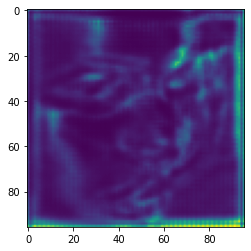

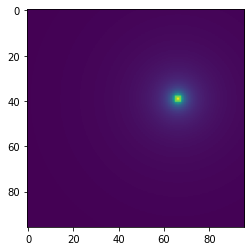

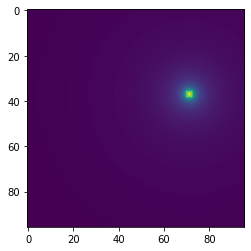

In [14]:
heatMap_img = heatMaps[26][0].cpu().numpy()
plt.imshow(heatMap_img)

plt.figure()
gtmap_img = gtmap[0][0].cpu().numpy()
plt.imshow(gtmap_img)

plt.figure()
gtmap_img = gtmap[3][0].cpu().numpy()
plt.imshow(gtmap_img)

print(myLoss.calLoss(gtmap[0:3], anno, gtmap[4:7]))
print(myLoss.calLoss(heatMaps, anno, gtmap))
